In [23]:
from copy import deepcopy
import cupy as cp
from itertools import chain
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import torch
from typing import Optional, Tuple

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
np.random.seed(0)
torch.manual_seed(0)

Reference paper:

**\[1\]** Barrera, D., S. Crépey, E. Gobet, Hoang-Dung Nguyen, and B. Saadeddine. Learning value-at-risk and expected shortfall. Pre-print available at https://arxiv.org/abs/2209.06476, 2022.

## Helper function to construct the polynomial basis of the Gaussian toy-model in \[1\].

In [4]:
def construct_polynomial_basis(X):
    polynomial_basis = torch.empty((X.shape[0], X.shape[1]+(X.shape[1]*(X.shape[1]+1))//2+1), dtype=X.dtype, device=X.device)
    polynomial_basis[:, 0] = 1
    polynomial_basis[:, 1:X.shape[1]+1] = X
    offset = 0
    for i in range(X.shape[1]):
        s = X.shape[1] - i
        polynomial_basis[:, X.shape[1]+offset+1:X.shape[1]+offset+s+1] = X[:, i, None]*X[:, i:]
        offset += s
    return polynomial_basis

## Helper function to compute the conditional mean and standard deviation under the toy-model

In [5]:
def compute_true_mean_std(X, lam1, lam2):
    Z = construct_polynomial_basis(X)
    mean = Z@lam1
    std = torch.abs(Z@lam2)
    return mean, std

## Helper function to compute the groundtruth VaR

In [6]:
def compute_true_VaR(alpha, mean, std):
    if not isinstance(alpha, torch.Tensor):
        return mean+std*norm.ppf(1-alpha)
    else:
        return mean+std*torch.as_tensor(norm.ppf(1-alpha.cpu().numpy()), device=alpha.device)

## Helper function to compute the groundtruth ES

In [7]:
def compute_true_ES(alpha, mean, std):
    if not isinstance(alpha, torch.Tensor):
        return mean+std*(norm.pdf(norm.ppf(1-alpha))/alpha)
    else:
        return mean+std*torch.as_tensor(norm.pdf(norm.ppf(1-alpha.cpu().numpy())), device=alpha.device, dtype=torch.float32)/alpha

## Putting it all together to construct the dataset under our gaussian model

In [8]:
def construct_dataset(lam1, lam2, dim, num_samples, device):
    assert lam1.shape == lam2.shape
    assert len(lam1.shape) == 1
    assert lam1.shape[0] == 1+dim+(dim*(dim+1))//2
    X = torch.randn((num_samples, dim), dtype=torch.float32, device=device)
    mean, std = compute_true_mean_std(X, lam1, lam2)
    Y = torch.randn((num_samples, 1), dtype=torch.float32, device=device)*std[:, None]+mean[:, None]
    return X, Y, mean, std

## Building blocks to define the networks for the multi-$\alpha$ and single-$\alpha$ approaches

In [9]:
class AffineSoftplus(torch.nn.Module):
    def __init__(self, dim_in: int, dim_out: int):
        super().__init__()
        self.W = torch.nn.Parameter(torch.empty(dim_in, dim_out, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.empty(1, dim_out, dtype=torch.float32))
        self.activation = torch.nn.Softplus()
        self.diff_activation = torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = torch.matmul(x, self.W) + self.b
        y = self.activation(z)
        return y
    
    @torch.jit.export
    def forward_diff(self, x: torch.Tensor, dy_prev: Optional[torch.Tensor], only_first_diff: bool) -> Tuple[torch.Tensor, torch.Tensor]:
        z = torch.matmul(x, self.W) + self.b
        diff_activation = self.diff_activation(z).unsqueeze(1)
        if only_first_diff:
            W = self.W[0].unsqueeze(0)
        else:
            W = self.W
        W = W.unsqueeze(0)
        y = self.activation(z)
        if dy_prev is not None:
            dy = (dy_prev @ W) * diff_activation
        else:
            dy = W * diff_activation
        return y, dy

class Affine(torch.nn.Module):
    def __init__(self, dim_in: int, dim_out: int):
        super().__init__()
        self.W = torch.nn.Parameter(torch.empty(dim_in, dim_out, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.empty(1, dim_out, dtype=torch.float32))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = torch.matmul(x, self.W) + self.b
        return y
    
    @torch.jit.export
    def forward_diff(self, x: torch.Tensor, dy_prev: Optional[torch.Tensor], only_first_diff: bool) -> Tuple[torch.Tensor, torch.Tensor]:
        y = torch.matmul(x, self.W) + self.b
        if only_first_diff:
            W = self.W[0].unsqueeze(0)
        else:
            W = self.W
        W = W.unsqueeze(0)
        if dy_prev is not None:
            dy = dy_prev @ W
        else:
            dy = W
        return y, dy

class ModelRandomAlpha(torch.nn.Module):
    def __init__(self, input_dim: int, num_hidden_layers: int, num_hidden_units: int):
        super().__init__()
        h = []
        dim_in = input_dim
        for i in range(num_hidden_layers):
            h.append(AffineSoftplus(dim_in, num_hidden_units))
            dim_in = num_hidden_units
        self.h = torch.nn.ModuleList(h)
        self.o = Affine(num_hidden_units, 1)
        self.register_buffer('x_mean', torch.zeros(1, input_dim, dtype=torch.float32))
        self.register_buffer('x_std', torch.ones(1, input_dim, dtype=torch.float32))
        self.register_buffer('y_mean', torch.zeros(1, 1, dtype=torch.float32))
        self.register_buffer('y_std', torch.ones(1, 1, dtype=torch.float32))
        for l in chain(self.h, (self.o,)):
            torch.nn.init.normal_(l.W, mean=0., std=np.sqrt(1/l.W.shape[0]))
            torch.nn.init.zeros_(l.b)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        a = (x-self.x_mean)/self.x_std
        for l in self.h:
            a = l(a)
        return self.o(a)*self.y_std+self.y_mean
    
    @torch.jit.export
    def forward_diff(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        a = (x-self.x_mean)/self.x_std
        a, da = self.h[0].forward_diff(a, None, True)
        da = da / self.x_std[:, 0, None, None]
        for l in self.h[1:]:
            a, da = l.forward_diff(a, da, False)
        a, da = self.o.forward_diff(a, da, False)
        a = a * self.y_std + self.y_mean
        da = da[:, :, 0] * self.y_std
        return a, da

class ModelRandomAlphaPiecewiseAffine(torch.nn.Module):
    def __init__(self, input_dim, num_hidden_layers, num_hidden_units, interpolation_nodes, bottleneck=False, positive_increments=True):
        super().__init__()
        h = []
        dim_in = input_dim-1
        for i in range(num_hidden_layers):
            if bottleneck and i==num_hidden_layers-1:
                h.append(AffineSoftplus(num_hidden_units, 1))
                break
            h.append(AffineSoftplus(dim_in, num_hidden_units))
            dim_in = num_hidden_units
        self.h = torch.nn.ModuleList(h)
        self.o = Affine(num_hidden_units if not bottleneck else 1, interpolation_nodes.shape[0])
        self.positive_increments = positive_increments
        self.register_buffer('x_mean', torch.zeros(1, input_dim, dtype=torch.float32))
        self.register_buffer('x_std', torch.ones(1, input_dim, dtype=torch.float32))
        self.register_buffer('y_mean', torch.zeros(1, 1, dtype=torch.float32))
        self.register_buffer('y_std', torch.ones(1, 1, dtype=torch.float32))
        self.register_buffer('interpolation_nodes', interpolation_nodes)
        self.register_buffer('interpolation_nodes_delta', interpolation_nodes[1:]-interpolation_nodes[:-1])
        for l in chain(self.h, (self.o,)):
            torch.nn.init.normal_(l.W, mean=0., std=np.sqrt(1/l.W.shape[0]))
            torch.nn.init.zeros_(l.b)

    def forward(self, x):
        a = (x[:, 1:]-self.x_mean[:, 1:])/self.x_std[:, 1:]
        for l in self.h:
            a = l(a)
        a = self.o(a)
        if self.positive_increments:
            a = a[:, 0, None]+torch.nn.functional.softplus((torch.minimum(x[:, 0, None], self.interpolation_nodes[None, 1:])-self.interpolation_nodes[None, :-1])*(self.interpolation_nodes[None, :-1]>=x[:, 0, None])*a[:, 1:]/self.interpolation_nodes_delta[None, :]).sum(1, keepdim=True)
        else:
            a = a[:, 0, None]+((torch.minimum(x[:, 0, None], self.interpolation_nodes[None, 1:])-self.interpolation_nodes[None, :-1])*(self.interpolation_nodes[None, :-1]>=x[:, 0, None])*a[:, 1:]/self.interpolation_nodes_delta[None, :]).sum(1, keepdim=True)
        return a*self.y_std+self.y_mean

## The loss function for the quantile learning

In [10]:
@torch.jit.script
def _var_loss(y_pred: torch.Tensor, y_true: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.relu(y_true-y_pred)+alpha*y_pred)

## A training routine for the single-$\alpha$ approach

In [11]:
def train_single_var(model, X, Y, X_valid, Y_valid, alpha, batch_size, lr, num_epochs):
    assert X.shape[0] == Y.shape[0]
    assert Y.shape[1] == 1
    assert isinstance(alpha, torch.Tensor)
    device = next(model.parameters()).device
    optimizer = torch.optim.Adam(model.parameters())
    model.x_mean.copy_(X.mean(0)[None, :])
    model.x_std.copy_(X.std(0)[None, :])
    model.y_mean.copy_(Y.mean(0)[None, :])
    model.y_std.copy_(Y.std(0)[None, :])
    with torch.no_grad():
        valid_loss = 0
        for b in range((X_valid.shape[0]+batch_size-1)//batch_size):
            idx = slice(b*batch_size, (b+1)*batch_size)
            Y_pred_valid = model(X_valid[idx])
            valid_loss += _var_loss(Y_pred_valid, Y_valid[idx], alpha)/model.y_std
        # assuming X_valid.shape[0] is a multiple of batch_size
        valid_loss /= b+1
        valid_loss = valid_loss.item()
    best_state_dict = deepcopy(model.state_dict())
    best_valid_loss = valid_loss
    losses = [(valid_loss, best_valid_loss)]
    for e in range(num_epochs):
        for group in optimizer.param_groups:
            group['lr'] = lr/np.sqrt(e+1)
        for b in range((X.shape[0]+batch_size-1)//batch_size):
            idx = slice(b*batch_size, (b+1)*batch_size)
            optimizer.zero_grad()
            Y_pred = model(X[idx])
            loss = _var_loss(Y_pred, Y[idx], alpha)/model.y_std[0, 0]
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            valid_loss = 0
            for b in range((X_valid.shape[0]+batch_size-1)//batch_size):
                idx = slice(b*batch_size, (b+1)*batch_size)
                Y_pred_valid = model(X_valid[idx])
                valid_loss += _var_loss(Y_pred_valid, Y_valid[idx], alpha)/model.y_std
            # assuming X_valid.shape[0] is a multiple of batch_size
            valid_loss /= b+1
            valid_loss = valid_loss.item()
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            for k, v in best_state_dict.items():
                v.copy_(model.state_dict()[k])
        losses.append((valid_loss, best_valid_loss))
        if e % 20 == 0:
            print('.', end='')
    model.load_state_dict(best_state_dict)
    print(' Done!')
    return losses

## A training routine for the multi-$\alpha$ approaches

In [12]:
def train_multiple_var(model, X, Y, X_valid, Y_valid, batch_size, lr, num_epochs, gamma=None):
    assert X.shape[0] == Y.shape[0]
    assert Y.shape[1] == 1
    device = next(model.parameters()).device
    optimizer = torch.optim.Adam(model.parameters())
    model.x_mean.copy_(X.mean(0)[None, :])
    model.x_std.copy_(X.std(0)[None, :])
    model.y_mean.copy_(Y.mean(0)[None, :])
    model.y_std.copy_(Y.std(0)[None, :])
    alphas = X[:, 0, None]
    alphas_valid = X_valid[:, 0, None]
    with torch.no_grad():
        monotonicity_penalty_valid = 0
        valid_loss = 0
        for b in range((X_valid.shape[0]+batch_size-1)//batch_size):
            idx = slice(b*batch_size, (b+1)*batch_size)
            if gamma is None:
                Y_pred_valid = model(X_valid[idx])
            else:
                Y_pred_valid, dY_pred_valid = model.forward_diff(X_valid[idx])
                monotonicity_penalty_valid += gamma*torch.relu(dY_pred_valid).mean()/model.y_std[0, 0]*model.x_std[0, 0]
            valid_loss += _var_loss(Y_pred_valid, Y_valid[idx], alphas_valid[idx])/model.y_std
        if gamma is not None:
            monotonicity_penalty_valid /= b+1
            monotonicity_penalty_valid = monotonicity_penalty_valid.item()
        valid_loss /= b+1
        valid_loss = valid_loss.item()
    best_state_dict = deepcopy(model.state_dict())
    selection_score = valid_loss + monotonicity_penalty_valid
    best_selection_score = selection_score
    losses = [(valid_loss, monotonicity_penalty_valid, selection_score, best_selection_score)]
    for e in range(num_epochs):
        for group in optimizer.param_groups:
            group['lr'] = lr/np.sqrt(e+1)
        for b in range((X.shape[0]+batch_size-1)//batch_size):
            idx = slice(b*batch_size, (b+1)*batch_size)
            optimizer.zero_grad()
            if gamma is None:
                Y_pred = model(X[idx])
                monotonicity_penalty = 0
            else:
                Y_pred, dY_pred = model.forward_diff(X[idx])
                monotonicity_penalty = gamma*torch.relu(dY_pred).mean()/model.y_std[0, 0]*model.x_std[0, 0]
            loss = _var_loss(Y_pred, Y[idx], alphas[idx])/model.y_std[0, 0] + monotonicity_penalty
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            monotonicity_penalty_valid = 0
            valid_loss = 0
            for b in range((X_valid.shape[0]+batch_size-1)//batch_size):
                idx = slice(b*batch_size, (b+1)*batch_size)
                if gamma is None:
                    Y_pred_valid = model(X_valid[idx])
                else:
                    Y_pred_valid, dY_pred_valid = model.forward_diff(X_valid[idx])
                    monotonicity_penalty_valid += gamma*torch.relu(dY_pred_valid).mean()/model.y_std[0, 0]*model.x_std[0, 0]
                valid_loss += _var_loss(Y_pred_valid, Y_valid[idx], alphas_valid[idx])/model.y_std
            if gamma is not None:
                monotonicity_penalty_valid /= b+1
                monotonicity_penalty_valid = monotonicity_penalty_valid.item()
            valid_loss /= b+1
            valid_loss = valid_loss.item()
        selection_score = valid_loss + monotonicity_penalty_valid
        if selection_score < best_selection_score:
            best_selection_score = selection_score
            for k, v in best_state_dict.items():
                v.copy_(model.state_dict()[k])
        losses.append((valid_loss, monotonicity_penalty_valid, selection_score, best_selection_score))
        if e % 20 == 0:
            print('.', end='')
    model.load_state_dict(best_state_dict)
    print(' Done!')
    return losses

## ES one-shot learning using linear regression

The following assumes a neural network has had its hidden layers properly initialized with the weights of a VaR estimator. The ES learning here then consists in optimizing the least-squares error for the ES only over the weights of the output layer. Hence, this can be done using a simple linear regression.

In [13]:
def train_single_es_regr(model, X, Y, Y_var, alpha, batch_size):
    assert X.shape[0] == Y.shape[0]
    assert Y.shape[1] == 1
    assert isinstance(alpha, torch.Tensor)
    device = next(model.parameters()).device
    model.x_mean.copy_(X.mean(0)[None, :])
    model.x_std.copy_(X.std(0)[None, :])
    with torch.no_grad():
        es_Y = (Y-Y_var).relu_().div_(alpha)+Y_var
    model.y_mean.copy_(es_Y.mean(0)[None, :])
    model.y_std.copy_(es_Y.std(0)[None, :])
    h_aug = torch.empty((batch_size, model.o.W.shape[0]+1), dtype=torch.float32, device=device)
    h_aug[:, 0] = 1
    with torch.no_grad():
        model.o.W.zero_()
        model.o.b.zero_()
        for b in range((X.shape[0]+batch_size-1)//batch_size):
            idx = slice(b*batch_size, (b+1)*batch_size)
            h = X[idx]
            for l in model.h:
                h = l(h)
            h_aug[:, 1:] = h
            with cp.cuda.Device(device.index):
                sol, _, _, _ = cp.linalg.lstsq(cp.asarray(h_aug), cp.asarray((es_Y[idx]-model.y_mean)/model.y_std), rcond=None)
                sol = torch.as_tensor(sol, device=device)
            model.o.W.add_(sol[1:h_aug.shape[1]])
            model.o.b.add_(sol[:1])
        model.o.W /= b+1
        model.o.b /= b+1
    print(' Done!')

## Helper functions to be able to also use multi-$\alpha$ networks when learning the ES using the linear regression trick

In [14]:
def piecewiseaffinevar_to_singlevar(alpha, model):
    with torch.no_grad():
        num_layers = len(model.h)
        W0 = model.h[0].W
        dim = W0.shape[0]
        num_units = W0.shape[1]
        device = W0.device
        singlevar_model = torch.jit.script(ModelRandomAlpha(dim, num_layers, num_units).to(device))
        singlevar_model.x_mean.copy_(model.x_mean[:, 1:])
        singlevar_model.x_std.copy_(model.x_std[:, 1:])
        singlevar_model.y_mean.copy_(model.y_mean)
        singlevar_model.y_std.copy_(model.y_std)
        for k in range(num_layers):
            singlevar_model.h[k].W.copy_(model.h[k].W)
            singlevar_model.h[k].b.copy_(model.h[k].b)
        v = torch.empty(model.o.W.shape[1], 1, dtype=torch.float32, device=device)
        alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
        v[0, 0] = 1
        v[1:, 0] = (torch.minimum(alpha, model.interpolation_nodes[1:])-model.interpolation_nodes[:-1])*(model.interpolation_nodes[:-1]>=alpha)/model.interpolation_nodes_delta
        singlevar_model.o.W.copy_(torch.mm(model.o.W, v))
        singlevar_model.o.b.copy_(torch.mm(model.o.b, v))
    return singlevar_model

def randomalphavar_to_singlevar(alpha, model):
    with torch.no_grad():
        num_layers = len(model.h)
        mean = model.x_mean[0, 0]
        std = model.x_std[0, 0]
        W0 = model.h[0].W
        b0 = model.h[0].b
        dim = W0.shape[0]-1
        num_units = W0.shape[1]
        device = W0.device
        singlevar_model = torch.jit.script(ModelRandomAlpha(dim, num_layers, num_units).to(device))
        singlevar_model.x_mean.copy_(model.x_mean[:, 1:])
        singlevar_model.x_std.copy_(model.x_std[:, 1:])
        singlevar_model.y_mean.copy_(model.y_mean)
        singlevar_model.y_std.copy_(model.y_std)
        singlevar_model.h[0].W.copy_(W0[1:])
        singlevar_model.h[0].b.copy_(b0)
        singlevar_model.h[0].b.add_(((alpha-mean)/std)*W0[0, None])
        for k in range(1, num_layers):
            singlevar_model.h[k].W.copy_(model.h[k].W)
            singlevar_model.h[k].b.copy_(model.h[k].b)
        singlevar_model.o.W.copy_(model.o.W)
        singlevar_model.o.b.copy_(model.o.b)
    return singlevar_model

## Training

In [15]:
# we use the first CUDA device available
device = torch.device('cuda:0')

# setting the total size of the sample (half of which is going to be used for training)
num_samples = 2**20

# assuming a dimensionality of 25 for X
dim = 25

# constructing the coefficients of the mean and std polynomials randomly
lam1 = torch.randn(1+dim+(dim*(dim+1))//2, dtype=torch.float32, device=device)
lam2 = torch.randn(1+dim+(dim*(dim+1))//2, dtype=torch.float32, device=device)

# constructing the data-set
X, Y, mean, std = construct_dataset(lam1, lam2, dim, num_samples, device)

# alpha is randomized and follows a Uniform distribution with the following bounds
alphas_lower_bound, alphas_upper_bound = 0.0001, 0.15

# creating another tensor where alpha is a covariate alongside X, necessary for the multi-alpha approaches
X_aug = torch.empty((X.shape[0], X.shape[1]+1), dtype=torch.float32, device=device)
X_aug[:, 0] = torch.rand(num_samples, dtype=torch.float32, device=device)*(alphas_upper_bound-alphas_lower_bound)+alphas_lower_bound
X_aug[:, 1:] = X

Now we construct the models.

In [16]:
models = {}; gamma = {}
single_alpha_grid = (0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1)

gamma['Multi-alpha I'] = 0.01
gamma['Multi-alpha II'] = None
gamma['Multi-alpha III'] = None

labels = {}
labels['Multi-alpha I'] = r'Multi-$\alpha$ I'
labels['Multi-alpha II'] = r'Multi-$\alpha$ II'
labels['Multi-alpha III'] = r'Multi-$\alpha$ III'

models['Multi-alpha I'] = torch.jit.script(ModelRandomAlpha(dim+1, 3, 2*(dim+1)).to(device))
models['Multi-alpha II'] = torch.jit.script(ModelRandomAlpha(dim+1, 3, 2*(dim+1)).to(device))
models['Multi-alpha III'] = torch.jit.script(ModelRandomAlphaPiecewiseAffine(dim+1, 3, 2*(dim+1), torch.linspace(0.001, 0.15, 21, dtype=torch.float32), bottleneck=False, positive_increments=False).to(device))

single_alpha_models = {alpha: torch.jit.script(ModelRandomAlpha(dim, 3, 2*dim)).to(device) for alpha in single_alpha_grid}

In [17]:
es_models_singlealpha = {alpha: torch.jit.script(ModelRandomAlpha(dim, 3, 2*dim)).to(device) for alpha in single_alpha_grid}
es_models_multialpha_1 = {alpha: torch.jit.script(ModelRandomAlpha(dim, 3, 2*(dim+1))).to(device) for alpha in single_alpha_grid}
es_models_multialpha_2 = {alpha: torch.jit.script(ModelRandomAlpha(dim, 3, 2*(dim+1))).to(device) for alpha in single_alpha_grid}
es_models_multialpha_3 = {alpha: torch.jit.script(ModelRandomAlpha(dim, 3, 2*(dim+1))).to(device) for alpha in single_alpha_grid}

Using a size of $2^{15}$ for the batches in the mini-batch Adam iterations, and limiting the training to only half of the dataset, so that the other half could be used as a validation set to select the best iterate during training.

In [18]:
train_valid_cutoff = num_samples//2
batch_size = 2**15

Creating our CUDA events to do the timings.

In [19]:
evt_start = torch.cuda.Event(enable_timing=True)
evt_stop = torch.cuda.Event(enable_timing=True)

We first train the multi-$\alpha$ VaR models.

In [20]:
losses = {}
for k, v in models.items():
    print('* Training {}'.format(k))
    evt_start.record()
    losses[k] = train_multiple_var(v, X_aug[:train_valid_cutoff], Y[:train_valid_cutoff], X_aug[train_valid_cutoff:], Y[train_valid_cutoff:], batch_size, 0.01, 2000, gamma=gamma[k])
    evt_stop.record()
    evt_stop.synchronize()
    print('Elapsed time: {} secs'.format(round((evt_start.elapsed_time(evt_stop))/1000, 2)))

* Training Multi-alpha I
.................................................................................................... Done!
Elapsed time: 412.72 secs
* Training Multi-alpha II
.................................................................................................... Done!
Elapsed time: 64.7 secs
* Training Multi-alpha III
.................................................................................................... Done!
Elapsed time: 81.05 secs


Now we train different VaR estimators using the single-$\alpha$ approach for different values of $\alpha$.

In [21]:
single_alpha_losses = {}
for alpha, model in single_alpha_models.items():
    print('* Training for alpha = {}'.format(alpha))
    evt_start.record()
    single_alpha_losses[alpha] = train_single_var(model, X[:train_valid_cutoff], Y[:train_valid_cutoff], X[train_valid_cutoff:], Y[train_valid_cutoff:], torch.tensor(alpha, device=device), batch_size, 0.01, 2000)
    evt_stop.record()
    evt_stop.synchronize()
    print('Elapsed time: {} secs'.format(round((evt_start.elapsed_time(evt_stop))/1000, 2)))

* Training for alpha = 0.001
.................................................................................................... Done!
Elapsed time: 65.72 secs
* Training for alpha = 0.005
.................................................................................................... Done!
Elapsed time: 63.96 secs
* Training for alpha = 0.01
.................................................................................................... Done!
Elapsed time: 66.2 secs
* Training for alpha = 0.02
.................................................................................................... Done!
Elapsed time: 70.88 secs
* Training for alpha = 0.03
.................................................................................................... Done!
Elapsed time: 69.59 secs
* Training for alpha = 0.04
.................................................................................................... Done!
Elapsed time: 69.66 secs
* Training for alpha = 0.05
...........

Finally, we train the ES estimators. The learnings are extremely fast as only the output layer is trained using linear regression.

In [38]:
for alpha, model in es_models_singlealpha.items():
    print('* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = {}'.format(alpha))
    evt_start.record()
    model.load_state_dict(single_alpha_models[alpha].state_dict())
    with torch.no_grad():
        Y_var = single_alpha_models[alpha](X)
    train_single_es_regr(model, X[:train_valid_cutoff], Y[:train_valid_cutoff], Y_var[:train_valid_cutoff], torch.tensor(alpha, device=device), batch_size)
    evt_stop.record()
    evt_stop.synchronize()
    print('Elapsed time: {} secs'.format(round((evt_start.elapsed_time(evt_stop))/1000, 2)))

* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = 0.001
 Done!
Elapsed time: 0.15 secs
* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = 0.005
 Done!
Elapsed time: 0.25 secs
* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = 0.01
 Done!
Elapsed time: 0.11 secs
* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = 0.02
 Done!
Elapsed time: 0.11 secs
* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = 0.03
 Done!
Elapsed time: 0.11 secs
* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = 0.04
 Done!
Elapsed time: 0.1 secs
* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = 0.05
 Done!
Elapsed time: 0.11 secs
* Training ES (same weights as learned single-alpha VaR except for last layer) for alpha = 0.06
 Done!
Elapsed

In [25]:
for alpha, model in es_models_multialpha_1.items():
    print('* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = {}'.format(alpha))
    evt_start.record()
    var_model = randomalphavar_to_singlevar(alpha, models['Multi-alpha I'])
    with torch.no_grad():
        Y_var = var_model(X)
    model.load_state_dict(var_model.state_dict())
    train_single_es_regr(model, X[:train_valid_cutoff], Y[:train_valid_cutoff], Y_var[:train_valid_cutoff], torch.tensor(alpha, device=device), batch_size)
    evt_stop.record()
    evt_stop.synchronize()
    print('Elapsed time: {} secs'.format(round((evt_start.elapsed_time(evt_stop))/1000, 2)))

* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = 0.001
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = 0.005
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = 0.01
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = 0.02
 Done!
Elapsed time: 0.2 secs
* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = 0.03
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = 0.04
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = 0.05
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha I VaR except for last layer) for alpha = 0.06
 Done!

In [26]:
for alpha, model in es_models_multialpha_2.items():
    print('* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = {}'.format(alpha))
    evt_start.record()
    var_model = randomalphavar_to_singlevar(alpha, models['Multi-alpha II'])
    with torch.no_grad():
        Y_var = var_model(X)
    model.load_state_dict(var_model.state_dict())
    train_single_es_regr(model, X[:train_valid_cutoff], Y[:train_valid_cutoff], Y_var[:train_valid_cutoff], torch.tensor(alpha, device=device), batch_size)
    evt_stop.record()
    evt_stop.synchronize()
    print('Elapsed time: {} secs'.format(round((evt_start.elapsed_time(evt_stop))/1000, 2)))

* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = 0.001
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = 0.005
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = 0.01
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = 0.02
 Done!
Elapsed time: 0.15 secs
* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = 0.03
 Done!
Elapsed time: 0.17 secs
* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = 0.04
 Done!
Elapsed time: 0.15 secs
* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = 0.05
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha II VaR except for last layer) for alpha = 0.

In [27]:
for alpha, model in es_models_multialpha_3.items():
    print('* Training ES (same weights as learned multi-alpha III VaR except for last layer) for alpha = {}'.format(alpha))
    evt_start.record()
    var_model = piecewiseaffinevar_to_singlevar(alpha, models['Multi-alpha III'])
    with torch.no_grad():
        Y_var = var_model(X)
    model.load_state_dict(var_model.state_dict())
    train_single_es_regr(model, X[:train_valid_cutoff], Y[:train_valid_cutoff], Y_var[:train_valid_cutoff], torch.tensor(alpha, device=device), batch_size)
    evt_stop.record()
    evt_stop.synchronize()
    print('Elapsed time: {} secs'.format(round((evt_start.elapsed_time(evt_stop))/1000, 2)))

* Training ES (same weights as learned multi-alpha III VaR except for last layer) for alpha = 0.001
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha III VaR except for last layer) for alpha = 0.005
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha III VaR except for last layer) for alpha = 0.01
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha III VaR except for last layer) for alpha = 0.02
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha III VaR except for last layer) for alpha = 0.03
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha III VaR except for last layer) for alpha = 0.04
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha III VaR except for last layer) for alpha = 0.05
 Done!
Elapsed time: 0.14 secs
* Training ES (same weights as learned multi-alpha III VaR except for last layer) for al

## A few histograms

### Single-$\alpha$ VaR vs groundtruth VaR

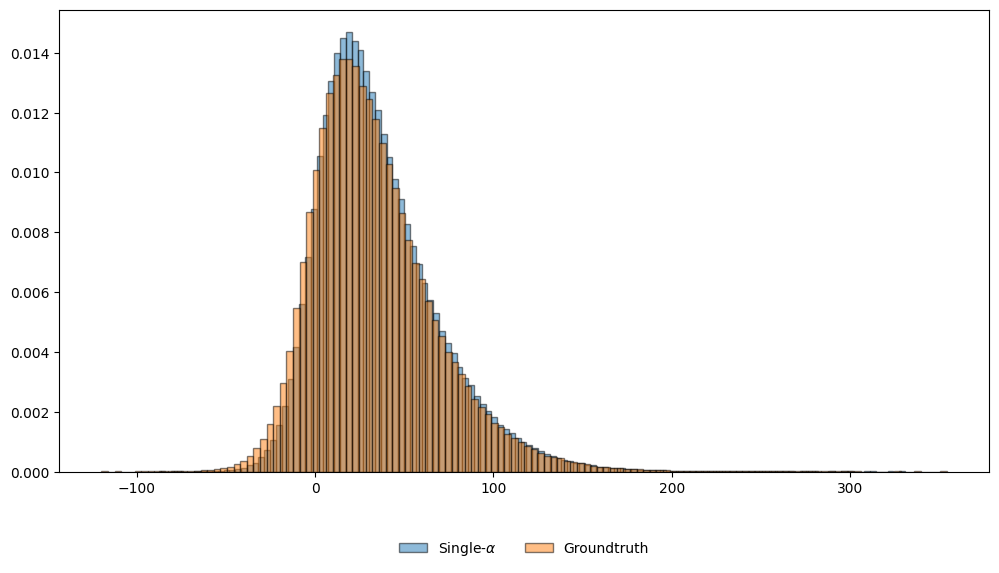

In [28]:
fig = plt.figure(figsize=(12, 6), dpi=100)
with torch.no_grad():
    alpha = 0.01
    plt.hist(single_alpha_models[alpha](X[train_valid_cutoff:]).squeeze().cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'Single-$\alpha$', ec='black')
    plt.hist(compute_true_VaR(alpha, mean[train_valid_cutoff:], std[train_valid_cutoff:]).cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'Groundtruth', ec='black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

### Learned ES (using same hidden layers as single-$\alpha$ VaR) vs groundtruth ES

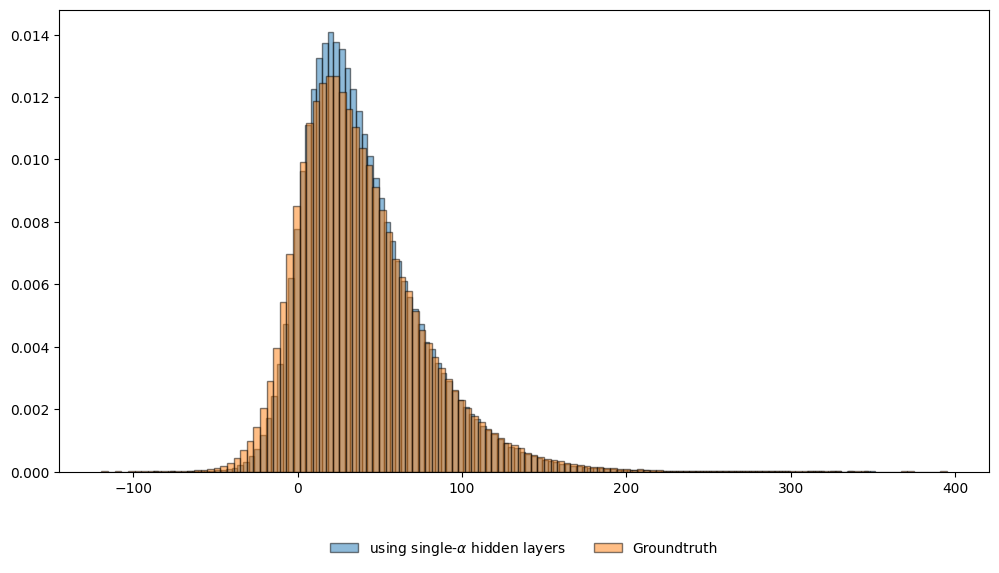

In [39]:
fig = plt.figure(figsize=(12, 6), dpi=100)
with torch.no_grad():
    alpha = 0.01
    plt.hist(es_models_singlealpha[alpha](X[train_valid_cutoff:]).squeeze().cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'using single-$\alpha$ hidden layers', ec='black')
    plt.hist(compute_true_ES(alpha, mean[train_valid_cutoff:], std[train_valid_cutoff:]).cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'Groundtruth', ec='black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

### Multi-$\alpha$ VaRs vs groundtruth VaR

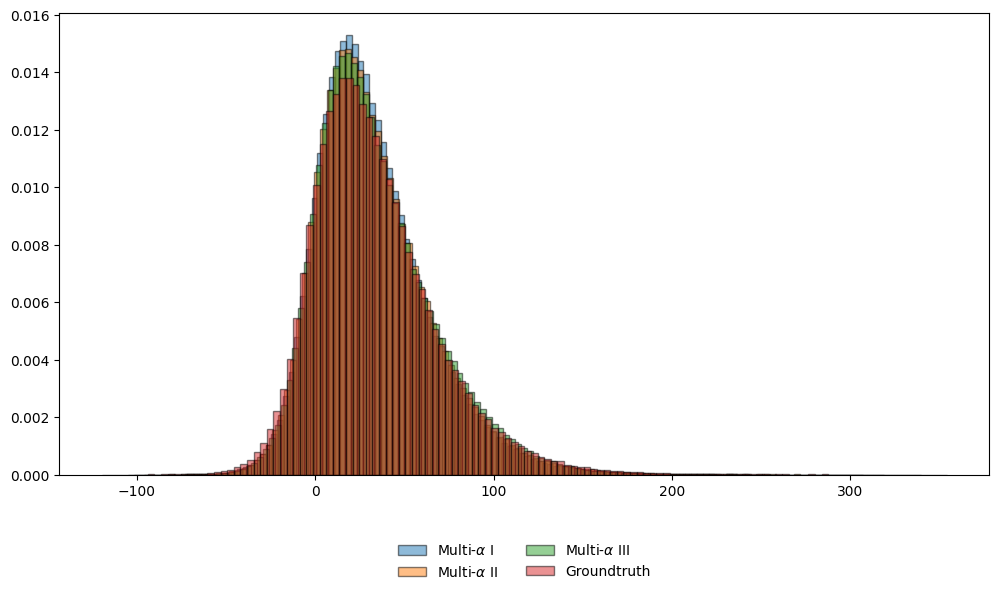

In [29]:
fig = plt.figure(figsize=(12, 6), dpi=100)
with torch.no_grad():
    alpha = 0.01
    X_aug_test = torch.empty((X.shape[0]-train_valid_cutoff, X.shape[1]+1), dtype=torch.float32, device=device)
    X_aug_test[:, 0] = alpha
    X_aug_test[:, 1:] = X[train_valid_cutoff:]
    for k, v in models.items():
        plt.hist(v(X_aug_test).squeeze().cpu().numpy(), bins=128, alpha=0.5, density=True, label=labels[k], ec='black')
    plt.hist(compute_true_VaR(alpha, mean[train_valid_cutoff:], std[train_valid_cutoff:]).cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'Groundtruth', ec='black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

### Learned ES (using multi-$\alpha$ VaRs' hidden layers) vs groundtruth ES

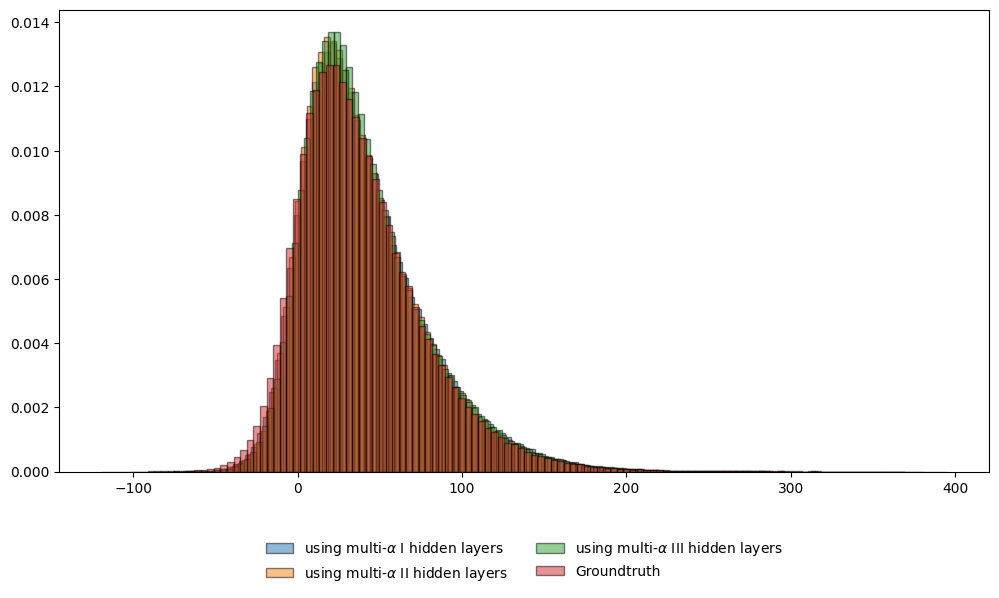

In [34]:
fig = plt.figure(figsize=(12, 6), dpi=100)
with torch.no_grad():
    alpha = 0.01
    plt.hist(es_models_multialpha_1[alpha](X[train_valid_cutoff:]).squeeze().cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'using multi-$\alpha$ I hidden layers', ec='black')
    plt.hist(es_models_multialpha_2[alpha](X[train_valid_cutoff:]).squeeze().cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'using multi-$\alpha$ II hidden layers', ec='black')
    plt.hist(es_models_multialpha_3[alpha](X[train_valid_cutoff:]).squeeze().cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'using multi-$\alpha$ III hidden layers', ec='black')
    plt.hist(compute_true_ES(alpha, mean[train_valid_cutoff:], std[train_valid_cutoff:]).cpu().numpy(), bins=128, alpha=0.5, density=True, label=r'Groundtruth', ec='black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);